# Temporal Event Positions

In this notebook, we infer the temporal event positions from the MHN posterior samples.

In [ ]:
from utils import analysis, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

burn_in = 0.2

In [ ]:
data_name = "G13_LUAD_12"  # change to "G13_COAD_12" for COAD dataset

samples = np.load(
    "../results/mcmc/G13_LUAD_12_symsparse_MALA_0_0015185546875000002.npy"
    if data_name == "G13_LUAD_12"
    else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")[:, ::100]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [ ]:
n_bins = 100
positions = analysis.event_positions(
    log_thetas=samples, n_bins=n_bins, n_samples="all")

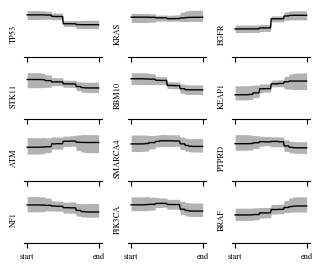

In [14]:
if data_name == "G13_LUAD_12":
    main_events =  np.arange(12)
elif data_name == "G13_COAD_12":
    main_events =  np.arange(12)

n_events = data.shape[1]
event_names = data.columns.tolist()
                            
n_cols = 3
n_rows = (len(main_events) - 1) // n_cols + 1

fig, ax = plt.subplots(
    n_rows, n_cols,
    figsize=(3.21, 2.8),
    sharex=True,
            )

for i, i_event in enumerate(main_events):

    q_5, q_50, q_95 = np.percentile(
        positions[:, i_event, :], [5, 50, 95], axis=0)
    ax[i // n_cols, i % n_cols].plot(
        q_50, lw=1, color="black")
    ax[i // n_cols, i % n_cols].fill_between(
        np.arange(n_bins), q_5, q_95, alpha=0.3, color="black", lw=0
    )
    ax[i // n_cols, i % n_cols].set_ylabel(f"{event_names[i_event]}")
    for spine in ["top", "right", "left"]:
        ax[i // n_cols, i % n_cols].spines[spine].set_visible(False)
    _ = ax[i // n_cols, i % n_cols].set_yticks([])
    _ = ax[i // n_cols, i % n_cols].set_xticks([0, n_bins-1])
    _ = ax[i // n_cols, i % n_cols].set_xticklabels(["start", "end"])
    ax[i // n_cols, i % n_cols].set_ylim(0, None, auto=True)

if len(main_events) % n_cols != 0:
    for i in range(n_cols - (len(main_events) % n_cols)):
        ax[-1, -1 - i].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.3
                    )
fig.savefig(
    f"../results/figs/{data_name}_positions.pdf", dpi=600)